In [1]:
import torch
from torch.utils import data
from torchvision.transforms import Compose
from torchvision.models import resnet152
import os
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('..')
import fdc
from dataset import NyuV2
import transforms_nyu

%matplotlib inline

In [2]:
data_path = '../data/nyu_v2/'

seed = 2
torch.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
depth_size = (25, 32)
model_input = 224
test_crop = (427, 561)
crop_ratios = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]

transform = Compose([
    transforms_nyu.Scale(),
    transforms_nyu.FDCPreprocess(crop_ratios)
])

nyu = NyuV2(os.path.join(data_path, 'train'), transform=transform)

dataloader = data.DataLoader(nyu, batch_size=1, shuffle=True, num_workers=6)

In [4]:
sample = next(iter(dataloader))

In [5]:
sample['stacked_images'].shape

torch.Size([1, 36, 3, 224, 224])

In [6]:
sample['depth'].shape

torch.Size([1, 800])

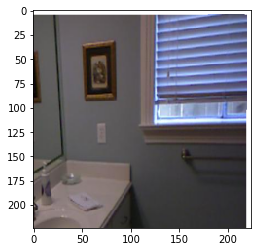

In [7]:
cropped_img = sample['stacked_images'][0][1]
cropped_img = cropped_img.permute(1,2,0)
plt.imshow(cropped_img)

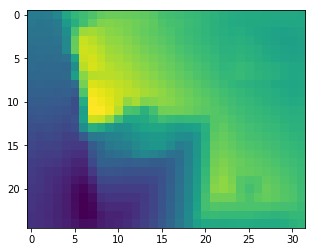

In [8]:
plt.imshow(sample['depth'][0].reshape(25,32))

In [9]:
fdc_model = fdc.FDC()

In [10]:
model = resnet152(pretrained=True)
model.fc = torch.nn.Linear(2048, depth_size[0] * depth_size[1])
wts = '../models/resnet_crop_test/114_model.pt'
model.load_state_dict(torch.load(wts))
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [11]:
f_m_hat, f = fdc_model.forward(model, dataloader)

In [20]:
f_m_hat[:, :, 0].shape

torch.Size([1200, 9])

In [18]:
f.shape

torch.Size([1200, 850])

In [27]:
import time
since = time.time()
T, M, K = f_m_hat.shape
weights = torch.zeros(M, K)
bias = torch.zeros(M, K)

for k in range(K):
    t_k = f[:, k].unsqueeze_(1)
    b_k = torch.mean(f_m_hat[:, :, k] - t_k, 0, True)
    T_k = f_m_hat[:, :, k] - b_k
    w_k = torch.mm(torch.pinverse(T_k), t_k)
    weights[:, k] = w_k.squeeze_()
    bias[:, k] = b_k.squeeze_()
    
time_elapsed = time.time() - since
print('Completed in {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed // 3600,
                                                                (time_elapsed // 60) % 60,
                                                                time_elapsed % 60))

Completed in 0h 0m 1s


In [ ]:
fdc_model.fit(f_m_hat, f)

In [ ]:
fdc_model.save_weights('../models/FDC/')

In [ ]:
img = sample['stacked_images'][0][0]
data = img.view(1, img.shape[0], img.shape[1], img.shape[2]).to(device)
with torch.no_grad():
    depth_maps = model(data)
d_hat = depth_maps[0].view(depth_size)

plt.figure()
plt.imshow(d_hat.cpu().data.numpy())

In [ ]:
data = sample['stacked_images'][0].to(device).float()
with torch.no_grad():
    result = model(data)
candidates = fdc_model.merge_crops(result)
f_m_hat = fdc_model.img2fourier(candidates)
f_hat = fdc_model.predict(f_m_hat)
d_hat = fdc_model.fourier2img(f_hat.view(1, -1), depth_size)

plt.figure()
plt.imshow(d_hat[0])